In [141]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
                # print( f"Value(data={v})")
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s| data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [159]:
import math
class Value:
    def __init__(self,data, _children=(),_op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self.label = label
        self._backward = lambda:None
        
    def __repr__(self):
        return f"Value(data={self.data, self.label})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self, other),'+')
        # contained propagation
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
        
        
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        # contained propagation
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += (( other * self.data ** (other-1)) *  out.grad) 
        out._backward = _backward
        return out
        
    def __rmul__(self,other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
        
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1 )/ (math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')
        # contained propagation, only single not other.
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        # contained propagation, only single not other.
        def _backward():
            self.grad += (out.data * out.grad)
        out._backward = _backward
        return out
        
    # Overall backward to all
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

   

    
    
    

# Derivate of o wrt to the original features or values.


In [160]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label= 'w1')
w2 = Value(1.0, label= 'w2')


b = Value(6.8813735870195432, label= 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+ x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

# add non-linear
o = n.tanh()
o.label = 'o'
o.backward()




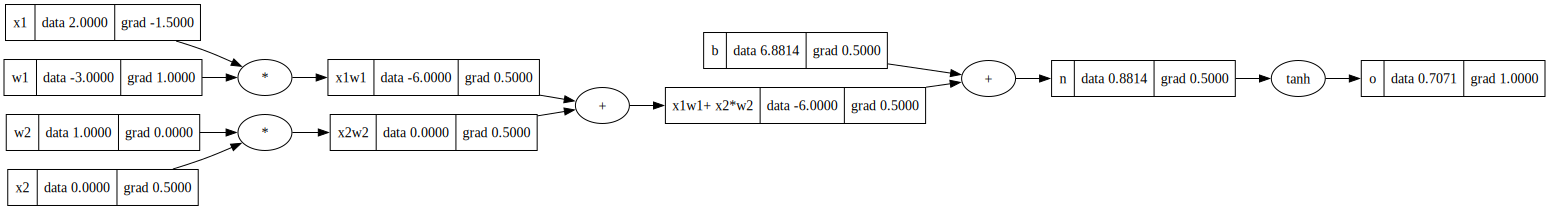

In [161]:
# o.backward()
draw_dot(o)

In [162]:
# Bug accumalte gradients, not just override.

In [163]:
a = Value(2.0)
b = Value(4.0)
#a / b = (a * b-1)
a-b


Value(data=(-2.0, ''))

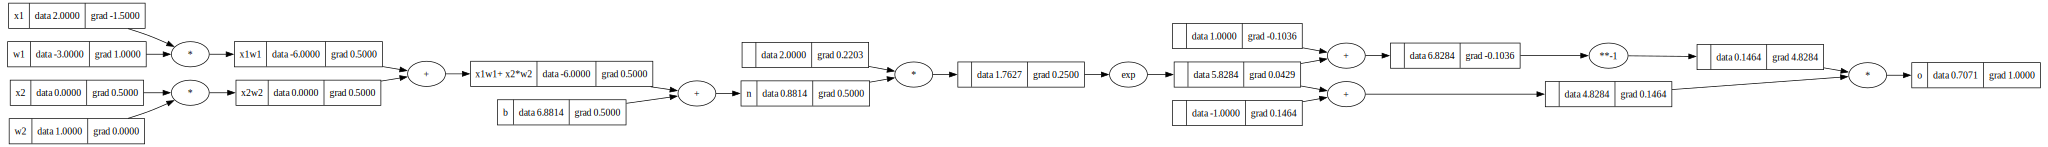

In [164]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label= 'w1')
w2 = Value(1.0, label= 'w2')


b = Value(6.8813735870195432, label= 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1+ x2*w2'
n = x1w1x2w2 + b ; n.label = 'n'

# add non-linear
#----------
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------
o.label = 'o'
o.backward()
draw_dot(o)




In [165]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True


n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('-----------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())

print('x1', x1.grad.item())
print('w1', w1.grad.item())

print('-----------------')

0.7071066904050358
-----------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
-----------------


In [166]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [167]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [168]:
torch.Tensor([2]).double().dtype

torch.float64

# Implement Neural network , 2 Layer perceptron.

In [169]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        # w*x +b 
        act = sum((wi*xi for wi,xi in zip(self.w,x)) , self.b)
        out = act.tanh()
        return out
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts)) ]

    def __call__(self, x ):
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0,3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=(0.38848409601518685, ''))

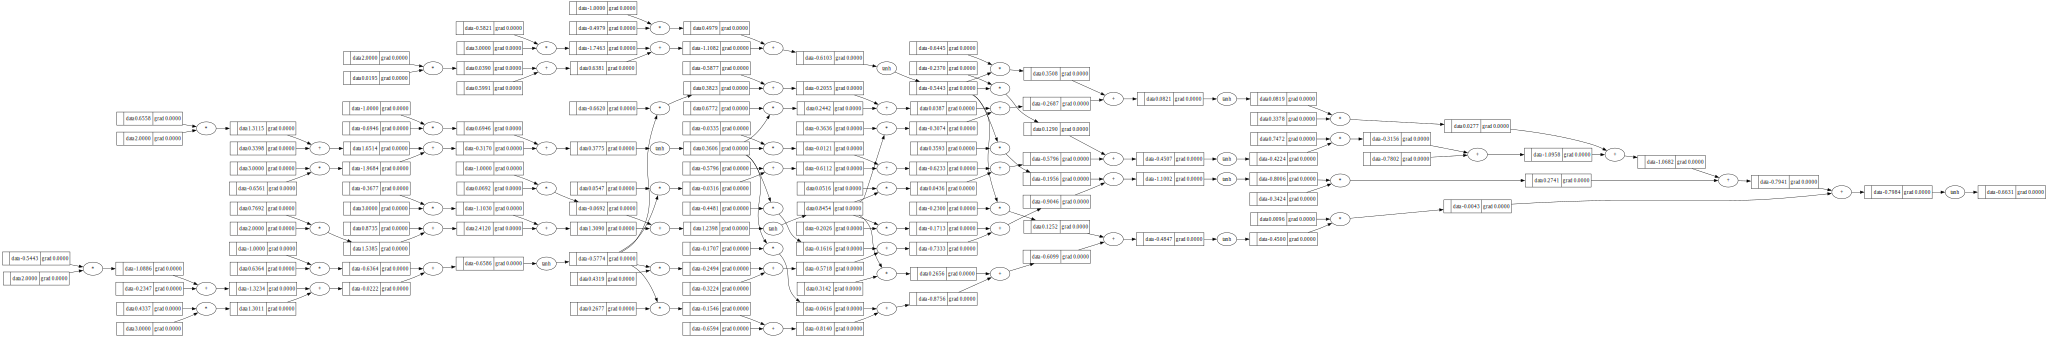

In [153]:
draw_dot(n(x))

In [170]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=(0.38848409601518685, '')),
 Value(data=(0.19759258760920703, '')),
 Value(data=(0.7143868555724925, '')),
 Value(data=(-0.18352668183579418, ''))]

In [171]:
# Pair up ground truth with o/p
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

# Random numbers so the values can change

Value(data=(6.148037403899862, ''))

In [172]:
loss.backward()

In [176]:
n.layers[0].neurons[0].w[0].grad

0.14194754746822247

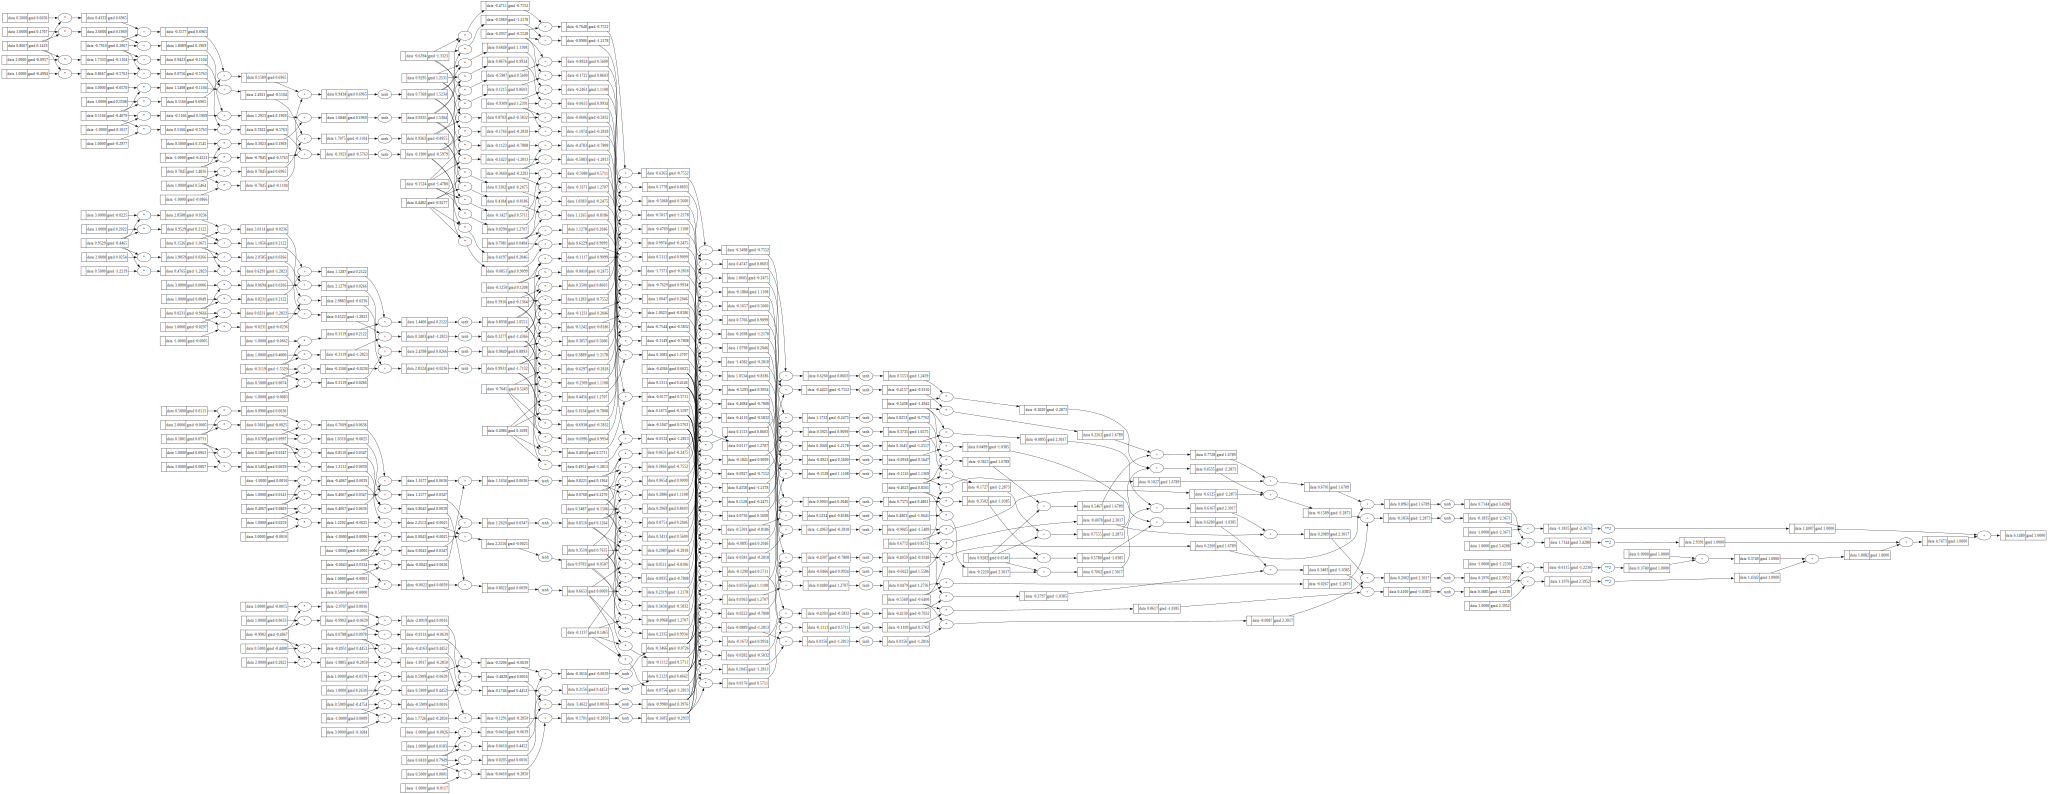

In [177]:
draw_dot(loss)